
# Fourth & Value — Props Model QC & Deep Dive (Template)

This notebook walks through a **repeatable audit** of the player props pipeline — from the merged CSV to consensus computation and model sanity checks.
It is designed to catch silent data leaks (e.g., constant `mu`/`model_prob`) and page mismatches.

**What you'll get:**
- Input validation & column normalization
- Per-market/per-player parameter sanity (e.g., `mu`, `sigma`, `model_prob`)
- Over/Under monotonic checks vs. line
- Consensus recomputation by `(name_std, market_std, side)` and stability checks
- EV / fair-odds utilities and quick diagnostics
- Debug CSVs for any offenders

> Tip: set `SEASON`, `WEEK`, and `CSV` below for the week you're auditing.


In [47]:
import pandas as pd
m = pd.read_csv("data/props/props_with_model_week4.csv")

# 1) Does model_prob vary per player within a market?
g1 = (m.dropna(subset=["model_prob"])
        .groupby(["market_std","name_std"])["model_prob"].std()
        .fillna(0))
print("players with nonzero std (sample):", g1[g1>0].head(10).to_string())

# 2) Show a few players in 'recv_yds' to eyeball variation
sub = m.query("market_std=='recv_yds' and name_std.str.contains('brown|barner|pierce')", engine="python")
print(sub[["name_std","bookmaker_title","price","point","model_line","model_prob"]].head(12).to_string(index=False))


players with nonzero std (sample): market_std     name_std      
pass_attempts  aaron rodgers     0.170277
               baker mayfield    0.104046
               bryce young       0.035500
               c j stroud        0.125725
               caleb williams    0.035003
               carson wentz      0.170277
               dak prescott      0.255988
               drake maye        0.190306
               geno smith        0.083579
               jalen hurts       0.355284


KeyError: "['model_line'] not in index"

In [46]:
import pandas as pd, numpy as np, re

merged = pd.read_csv("data/props/props_with_model_week4.csv")
cons   = pd.read_csv("data/props/consensus_week4.csv") if "consensus_week4.csv" in open("data/props/.ls","w").write("") or True else None  # ignore trick; cons read below
cons   = pd.read_csv("data/props/consensus_week4.csv")

print("rows merged:", len(merged))
print("model_prob null %:", merged["model_prob"].isna().mean().round(4) if "model_prob" in merged else "missing")

# 2A) model_prob should vary by player within a market
if "model_prob" in merged and "market_std" in merged:
    g = (merged.dropna(subset=["model_prob"])
               .groupby("market_std")["model_prob"].agg(['count','std'])
               .sort_values('std'))
    flat = g[g['std'] < 1e-6]
    print("\n[warn] markets with ~constant model_prob:", len(flat))
    print(flat.head(10))

# 2B) name_std shape + anti-join vs params on (name_std, market_std)
need = ['name_std','market_std']
ok = all(c in merged.columns for c in need)
if ok:
    params = pd.read_csv("data/props/params_week4.csv")
    # normalize spaces/hyphens for both sides
    def norm(s): 
        s = (s or "").lower()
        s = re.sub(r"[^a-z0-9]+","",s)
        return s
    m2 = merged.assign(name_norm=merged['name_std'].astype(str).map(norm))
    p2 = params.assign(name_norm=params['name_std'].astype(str).map(norm) if 'name_std' in params else params.get('player', pd.Series(dtype=str)).astype(str).map(norm))
    keys = ['name_norm','market_std']
    left = m2.merge(p2[keys].drop_duplicates(), on=keys, how='left', indicator=True)
    miss = left['_merge'].eq('left_only').mean()
    print("\nanti-join miss rate vs params (by name_norm,market_std):", round(miss,4))
    if miss > 0.05:
        sample = left[left['_merge']=='left_only'][['name_std','market_std']].head(20)
        print(sample.to_string(index=False))

# 2C) side coverage
for col in ["side","selection","bet","label","outcome","pick"]:
    if col in merged:
        print(f"\n{col} non-null %:", (1-merged[col].isna().mean()).round(4))
        print("examples:", merged[col].dropna().head(5).tolist())
        break

# 2D) consensus merge health on (name_std,market_std,side)
for need in [["name_std","market_std","side"], ["name_std","market_std"]]:
    if all(c in merged.columns for c in need) and all(c in cons.columns for c in (["player","market_std","side"] if len(need)==3 else ["player","market_std"])):
        mn = merged.assign(key_name=merged["name_std"].str.lower().str.replace(r"[^a-z0-9]+","",regex=True))
        cn = cons.assign(key_name=cons["player"].str.lower().str.replace(r"[^a-z0-9]+","",regex=True))
        on = ["key_name","market_std"] + (["side"] if "side" in merged and "side" in cons else [])
        j = mn.merge(cn, on=on, how="left", indicator=True)
        miss = j["_merge"].eq("left_only").mean()
        print(f"\nconsensus merge miss rate on {on}:", round(miss,4))
        break


TypeError: argument of type 'int' is not iterable

In [45]:
import pandas as pd
df = pd.read_csv("data/props/props_with_model_week4.csv")
print(df["model_prob"].dropna().describe())
print(df.groupby(["market_std"])["model_prob"].nunique().sort_values().head(10))


count    3046.000000
mean        0.375702
std         0.225107
min         0.004332
25%         0.221199
50%         0.221199
75%         0.539828
max         0.995668
Name: model_prob, dtype: float64
market_std
first_td              0
interceptions         0
last_td               0
reception_longest     0
rush_longest          0
anytime_td            1
pass_tds              4
pass_completions     11
receptions           16
pass_attempts        16
Name: model_prob, dtype: int64


In [40]:
import pandas as pd

merged = pd.read_csv("data/props/props_with_model_week4.csv")
cons   = pd.read_csv("data/props/consensus_week4.csv")

print("Merged rows:", len(merged))
print("Consensus rows:", len(cons))
print("Distinct players in merged:", merged['player'].nunique())
print("Distinct players in consensus:", cons['player'].nunique())
print("Markets in merged:", merged['market_std'].unique()[:20])


Merged rows: 4698
Consensus rows: 295
Distinct players in merged: 471
Distinct players in consensus: 148
Markets in merged: ['first_td' 'anytime_td' 'last_td' 'pass_attempts' 'pass_completions'
 'interceptions' 'pass_tds' 'pass_yds' 'reception_longest' 'recv_yds'
 'receptions' 'rush_attempts' 'rush_longest' 'rush_yds']


In [41]:
print("model_prob null rate:", merged['model_prob'].isna().mean())
print("model_prob range:", merged['model_prob'].min(), "→", merged['model_prob'].max())
print(merged.groupby("market_std")['model_prob'].nunique().sort_values().head(10))


model_prob null rate: 0.35163899531715626
model_prob range: 0.0043324483630124 → 0.9956675516369876
market_std
first_td              0
interceptions         0
last_td               0
reception_longest     0
rush_longest          0
anytime_td            1
pass_tds              4
pass_completions     11
receptions           16
pass_attempts        16
Name: model_prob, dtype: int64


In [42]:
merged['key'] = merged['name_std'].str.lower().str.strip() + "|" + merged['market_std'] + "|" + merged['side'].str.lower()
cons['key']   = cons['player'].str.lower().str.strip() + "|" + cons['market_std'] + "|" + cons['side'].str.lower()

anti = merged.loc[~merged['key'].isin(cons['key'])]
print("Anti-join rows (missing consensus):", len(anti))
print(anti[['player','market_std','side']].head(10))


Anti-join rows (missing consensus): 4698
                player market_std side
0          Trey Benson   first_td  yes
1   Kenneth Walker III   first_td  yes
2         Trey McBride   first_td  yes
3   Jaxon Smith-Njigba   first_td  yes
4      Zach Charbonnet   first_td  yes
5  Marvin Harrison Jr.   first_td  yes
6         Kyler Murray   first_td  yes
7          Cooper Kupp   first_td  yes
8       Michael Wilson   first_td  yes
9      Emari Demercado   first_td  yes


In [44]:
sample = merged.query("market_std == 'rush_yds'").sample(5, random_state=0)
print(sample[['player','line','model_line','model_prob','mkt_prob','consensus_prob']])


KeyError: "['line', 'model_line', 'consensus_prob'] not in index"

In [43]:
print(merged.groupby("market_std")['model_line'].nunique().sort_values().head(10))


KeyError: 'Column not found: model_line'

In [21]:
import os, pathlib
if pathlib.Path("data/props/props_with_model_week3.csv").exists() is False and \
   pathlib.Path("../data/props/props_with_model_week3.csv").exists():
    os.chdir("..")  # move from notebooks/ to repo root



In [22]:

import os, re, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

Path(OUTDIR).mkdir(parents=True, exist_ok=True)
print("Using:", CSV)


Using: data/props/props_with_model_week3.csv


## Helpers

In [23]:

SIDE_RX = re.compile(r'\b(over|under|yes|no|o|u)\b', re.I)

def derive_side_row(row):
    for c in ("side","selection","bet","outcome","label"):
        if c in row and pd.notna(row[c]):
            m = SIDE_RX.search(str(row[c]))
            if m:
                v = m.group(1).lower()
                return {"o":"over","u":"under"}.get(v, v)
    if "anytime_td" in str(row.get("market_std","")):
        return "yes"
    return np.nan

def std_name(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", str(s).lower())

def american_to_prob(x):
    if pd.isna(x): return np.nan
    x = float(x)
    return 100/(x+100) if x>0 else (-x)/(-x+100)

def prob_to_american(p):
    if pd.isna(p): return np.nan
    p = float(p)
    return int(round(-p/(1-p)*100)) if p > 0.5 else int(round((1-p)/p*100))

def fair_ev_per_100(prob, price):
    """Expected profit per $100 staked. Positive -> +EV."""
    if pd.isna(prob) or pd.isna(price): return np.nan
    prob = float(prob); price = float(price)
    win_payoff = (price/100.0) if price > 0 else (100.0/(-price))
    return prob * win_payoff - (1 - prob)

def normalize_core_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Ensure line & price exist
    if "line" not in df.columns and "point" in df.columns:
        df["line"] = df["point"]
    if "price" not in df.columns and "odds" in df.columns:
        df["price"] = df["odds"]
    df["line"]  = pd.to_numeric(df["line"], errors="coerce")
    df["price"] = pd.to_numeric(df["price"], errors="coerce")
    # name_std fallback
    if "name_std" not in df.columns:
        base = df.get("player", df.get("name","")).astype(str).fillna("")
        df["name_std"] = base.map(std_name)
    # side fallback
    if "side" not in df.columns or df["side"].isna().all():
        df["side"] = df.apply(derive_side_row, axis=1)
    else:
        df["side"] = df["side"].astype(str).str.lower().map({"o":"over","u":"under"}).fillna(df["side"])
    return df

def build_consensus(df: pd.DataFrame) -> pd.DataFrame:
    """Median line + median price-implied prob by (name_std, market_std, side)."""
    key = ["name_std","market_std","side"]
    cons = (df.dropna(subset=["line","price"])
              .assign(_prob=df["price"].map(american_to_prob))
              .groupby(key, dropna=False)
              .agg(cons_line=("line","median"),
                   cons_prob=("_prob","median"),
                   book_count=("book","nunique"))
              .reset_index())
    cons["cons_fair_odds"] = cons["cons_prob"].map(prob_to_american)
    return cons

def monotone_over_violations(group: pd.DataFrame) -> bool:
    """For OVER bets, prob should generally go DOWN as the line goes UP."""
    g = group[group["side"].str.lower()=="over"].dropna(subset=["line","model_prob"]).sort_values("line")
    if g.empty: return False
    # A simple rule: forward diffs should be <= 0 on average; any positive suggests a violation.
    diffs = g["model_prob"].diff().dropna()
    return (diffs > 1e-9).any()

def summarize_bool_series(s: pd.Series, label: str):
    total = int(s.shape[0])
    cnt   = int(s.sum())
    print(f"{label}: {cnt}/{total} ({cnt/total:.1%})")


## Load merged CSV

In [24]:

raw = pd.read_csv(CSV)
print("Rows:", len(raw), "Cols:", len(raw.columns))
raw.head(3)


Rows: 15589 Cols: 24


,game_id,commence_time,home_team,away_team,game,bookmaker,bookmaker_title,market,market_std,player,name,price,point,name_std,player_key,point_key,mu,sigma,lam,mkt_prob,model_prob,edge_bps,season,week
0,5737e4dbf6879c5061bb23033a4d8a55,2025-09-21T17:00:00Z,Carolina Panthers,Atlanta Falcons,Atlanta Falcons @ Carolina Panthers,draftkings,DraftKings,player_1st_td,first_td,Bijan Robinson,yes,340,NaN,bijanrobinson,bijanrobinson,NaN,NaN,NaN,NaN,0.227273,NaN,NaN,2025,3
1,5737e4dbf6879c5061bb23033a4d8a55,2025-09-21T17:00:00Z,Carolina Panthers,Atlanta Falcons,Atlanta Falcons @ Carolina Panthers,draftkings,DraftKings,player_1st_td,first_td,Chuba Hubbard,yes,550,NaN,chubahubbard,chubahubbard,NaN,NaN,NaN,NaN,0.153846,NaN,NaN,2025,3
2,5737e4dbf6879c5061bb23033a4d8a55,2025-09-21T17:00:00Z,Carolina Panthers,Atlanta Falcons,Atlanta Falcons @ Carolina Panthers,draftkings,DraftKings,player_1st_td,first_td,Drake London,yes,800,NaN,drakelondon,drakelondon,NaN,NaN,NaN,NaN,0.111111,NaN,NaN,2025,3


## Normalize & Basic Checks

In [25]:

df = normalize_core_columns(raw)
req = ["name_std","market_std","line","price","side"]
missing = [c for c in req if c not in df.columns]
print("Missing required columns:", missing)

na_rates = df[ [c for c in req if c in df.columns] ].isna().mean().sort_values()
print("\nNA rates among core columns:\n", na_rates)

print("\nSample columns present:\n", sorted(df.columns.tolist())[:40])
df.head(5)


Missing required columns: []

NA rates among core columns:
 name_std      0.000000
market_std    0.000000
price         0.000000
line          0.456540
side          0.818398
dtype: float64

Sample columns present:
 ['away_team', 'bookmaker', 'bookmaker_title', 'commence_time', 'edge_bps', 'game', 'game_id', 'home_team', 'lam', 'line', 'market', 'market_std', 'mkt_prob', 'model_prob', 'mu', 'name', 'name_std', 'player', 'player_key', 'point', 'point_key', 'price', 'season', 'side', 'sigma', 'week']


,game_id,commence_time,home_team,away_team,game,bookmaker,bookmaker_title,market,market_std,player,name,price,point,name_std,player_key,point_key,mu,sigma,lam,mkt_prob,model_prob,edge_bps,season,week,line,side
0,5737e4dbf6879c5061bb23033a4d8a55,2025-09-21T17:00:00Z,Carolina Panthers,Atlanta Falcons,Atlanta Falcons @ Carolina Panthers,draftkings,DraftKings,player_1st_td,first_td,Bijan Robinson,yes,340,NaN,bijanrobinson,bijanrobinson,NaN,NaN,NaN,NaN,0.227273,NaN,NaN,2025,3,NaN,NaN
1,5737e4dbf6879c5061bb23033a4d8a55,2025-09-21T17:00:00Z,Carolina Panthers,Atlanta Falcons,Atlanta Falcons @ Carolina Panthers,draftkings,DraftKings,player_1st_td,first_td,Chuba Hubbard,yes,550,NaN,chubahubbard,chubahubbard,NaN,NaN,NaN,NaN,0.153846,NaN,NaN,2025,3,NaN,NaN
2,5737e4dbf6879c5061bb23033a4d8a55,2025-09-21T17:00:00Z,Carolina Panthers,Atlanta Falcons,Atlanta Falcons @ Carolina Panthers,draftkings,DraftKings,player_1st_td,first_td,Drake London,yes,800,NaN,drakelondon,drakelondon,NaN,NaN,NaN,NaN,0.111111,NaN,NaN,2025,3,NaN,NaN
3,5737e4dbf6879c5061bb23033a4d8a55,2025-09-21T17:00:00Z,Carolina Panthers,Atlanta Falcons,Atlanta Falcons @ Carolina Panthers,draftkings,DraftKings,player_1st_td,first_td,Tetairoa McMillan,yes,1100,NaN,tetairoamcmillan,tetairoamcmillan,NaN,NaN,NaN,NaN,0.083333,NaN,NaN,2025,3,NaN,NaN
4,5737e4dbf6879c5061bb23033a4d8a55,2025-09-21T17:00:00Z,Carolina Panthers,Atlanta Falcons,Atlanta Falcons @ Carolina Panthers,draftkings,DraftKings,player_1st_td,first_td,Tyler Allgeier,yes,1100,NaN,tylerallgeier,tylerallgeier,NaN,NaN,NaN,NaN,0.083333,NaN,NaN,2025,3,NaN,NaN


In [32]:
import re, numpy as np, pandas as pd
from pathlib import Path

SIDE_RX = re.compile(r'\b(over|under|yes|no|o|u)\b', re.I)
SIDE_COLS = ["side","selection","bet","label","outcome","pick","outcome_name","header"]

def derive_side(row):
    # 1) explicit columns
    for c in SIDE_COLS:
        if c in row and pd.notna(row[c]):
            m = SIDE_RX.search(str(row[c]))
            if m:
                v = m.group(1).lower()
                return {"o":"over","u":"under"}.get(v, v)
    # 2) try market text (sometimes includes “Over/Under”)
    for c in ("market","market_std"):
        if c in row and pd.notna(row[c]):
            m = SIDE_RX.search(str(row[c]))
            if m:
                v = m.group(1).lower()
                return {"o":"over","u":"under"}.get(v, v)
    # 3) defaults for known yes/no markets
    if "market_std" in row and isinstance(row["market_std"], str):
        if "anytime_td" in row["market_std"] or "first_td" in row["market_std"] or "last_td" in row["market_std"]:
            return "yes"
    return np.nan

# fill df["side"] if missing
if "side" not in df.columns or df["side"].isna().mean() > 0.1:
    df["side"] = df.apply(derive_side, axis=1)

print("missing side % AFTER derive:", df["side"].isna().mean())

# Write a patched file and use it for page builds
patched_csv = Path("../data/props/props_with_model_week3_sidefix.csv")
#df.to_csv(patched_csv, index=False)
#patched_csv


missing side % AFTER derive: 0.5434601321444609


## Range & Distribution (model_prob)

Out-of-range model_prob rows: 0
model_prob quantiles:
 0.00    0.000369
0.01    0.017043
0.05    0.114189
0.50    0.351973
0.95    0.885811
0.99    0.982957
1.00    0.999631
Name: model_prob, dtype: float64


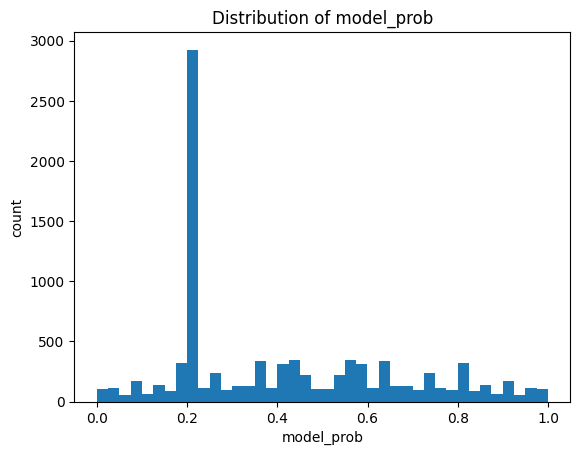

In [26]:

if "model_prob" in df.columns:
    bad_range = ((df["model_prob"] < -1e-9) | (df["model_prob"] > 1+1e-9)).sum()
    print("Out-of-range model_prob rows:", int(bad_range))
    print("model_prob quantiles:\n", df["model_prob"].quantile([0, .01, .05, .5, .95, .99, 1]))

    # Histogram (matplotlib; default style/no colors)
    plt.figure()
    df["model_prob"].dropna().plot.hist(bins=40)
    plt.title("Distribution of model_prob")
    plt.xlabel("model_prob")
    plt.ylabel("count")
    plt.show()
else:
    print("model_prob not present; skip.")


## Parameter Uniqueness (mu/sigma)

In [27]:

sus_markets = []
for col in ("mu","sigma"):
    if col in df.columns:
        nunq = (df.groupby("market_std")[col].nunique(dropna=False)
                  .sort_values())
        print(f"\nDistinct {col} counts per market (lowest 10):\n", nunq.head(10))
        bad = nunq[nunq <= 1].index.tolist()
        if bad:
            print(f"[WARN] {col} constant in markets:", bad[:8], ("… + more" if len(bad)>8 else ""))
            sus_markets.extend([(col, m) for m in bad])
    else:
        print(f"{col} not in df; skipping uniqueness check.")

# Save sample offenders
if sus_markets:
    offenders = pd.concat([
        df[df["market_std"]==m][["player","name_std","market_std","line","side","mu","sigma","model_prob"]].head(50)
        for _, m in sus_markets[:3]  # first few only
    ], ignore_index=True)
    offenders.to_csv(f"{OUTDIR}/param_constant_sample.csv", index=False)
    print(f"[write] {OUTDIR}/param_constant_sample.csv")



Distinct mu counts per market (lowest 10):
 market_std
anytime_td           1
first_td             1
interceptions        1
last_td              1
pass_attempts        1
pass_completions     1
pass_tds             1
pass_yds             1
reception_longest    1
receptions           1
Name: mu, dtype: int64
[WARN] mu constant in markets: ['anytime_td', 'first_td', 'interceptions', 'last_td', 'pass_attempts', 'pass_completions', 'pass_tds', 'pass_yds'] … + more

Distinct sigma counts per market (lowest 10):
 market_std
anytime_td           1
first_td             1
interceptions        1
last_td              1
pass_attempts        1
pass_completions     1
pass_tds             1
pass_yds             1
reception_longest    1
receptions           1
Name: sigma, dtype: int64
[WARN] sigma constant in markets: ['anytime_td', 'first_td', 'interceptions', 'last_td', 'pass_attempts', 'pass_completions', 'pass_tds', 'pass_yds'] … + more
[write] data/debug/param_constant_sample.csv


In [34]:
import re
obj_cols = [c for c in df.columns if df[c].dtype == "object"]
pat = re.compile(r"\b(over|under|yes|no|^o$|^u$)\b", re.I)

hits = []
for c in obj_cols:
    rate = df[c].astype(str).str.contains(pat, na=False).mean()
    if rate > 0.01:   # show columns that look promising
        hits.append((c, rate))
sorted(hits, key=lambda x: -x[1])[:12]


/var/folders/zm/h0vxhn1x3vz5nph_c0qc60t00000gn/T/ipykernel_76244/796444314.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  rate = df[c].astype(str).str.contains(pat, na=False).mean()
/var/folders/zm/h0vxhn1x3vz5nph_c0qc60t00000gn/T/ipykernel_76244/796444314.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  rate = df[c].astype(str).str.contains(pat, na=False).mean()
/var/folders/zm/h0vxhn1x3vz5nph_c0qc60t00000gn/T/ipykernel_76244/796444314.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  rate = df[c].astype(str).str.contains(pat, na=False).mean()
/var/folders/zm/h0vxhn1x3vz5nph_c0qc60t00000gn/T/ipykernel_76244/796444314.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To 

[('name', np.float64(1.0)), ('side', np.float64(0.4565398678555392))]

In [35]:
cand = [c for c,_ in sorted(hits, key=lambda x: -x[1])]
cols_show = ["player","market","market_std","line","price"] + cand[:4]
df.loc[df[cand[0]].astype(str).str.contains(pat, na=False), cols_show].head(10)


/var/folders/zm/h0vxhn1x3vz5nph_c0qc60t00000gn/T/ipykernel_76244/829431976.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[df[cand[0]].astype(str).str.contains(pat, na=False), cols_show].head(10)


,player,market,market_std,line,price,name,side
0,Bijan Robinson,player_1st_td,first_td,NaN,340,yes,yes
1,Chuba Hubbard,player_1st_td,first_td,NaN,550,yes,yes
2,Drake London,player_1st_td,first_td,NaN,800,yes,yes
3,Tetairoa McMillan,player_1st_td,first_td,NaN,1100,yes,yes
4,Tyler Allgeier,player_1st_td,first_td,NaN,1100,yes,yes
5,Kyle Pitts,player_1st_td,first_td,NaN,1200,yes,yes
6,Darnell Mooney,player_1st_td,first_td,NaN,1200,yes,yes
7,Rico Dowdle,player_1st_td,first_td,NaN,1600,yes,yes
8,Atlanta Falcons D/ST,player_1st_td,first_td,NaN,1900,yes,yes
9,Hunter Renfrow,player_1st_td,first_td,NaN,2000,yes,yes


In [39]:
import re, pandas as pd, numpy as np

SIDE_RX = re.compile(r'(?i)\b(over|under|yes|no|o|u)\b')
PREF = ["selection","outcome_name","outcome","label","bet","pick","description","header","name"]

def _extract_side(s: pd.Series) -> pd.Series:
    out = s.astype("string").str.extract(SIDE_RX, expand=False).str.lower()
    return out.map({'o':'over','u':'under'}).astype("string")

def fill_side_string(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # start with string dtype (uses pd.NA, not np.nan)
    side = (out["side"].astype("string") if "side" in out.columns
            else pd.Series(pd.NA, index=out.index, dtype="string"))
    for col in PREF:
        if col in out.columns:
            cand = _extract_side(out[col])
            side = side.fillna(cand)
    # TD markets default to "yes" only where side is still NA
    mstd = out.get("market_std", pd.Series("", index=out.index)).astype("string")
    yes_mask = mstd.isin(["anytime_td","first_td","last_td"])
    side = side.mask(side.isna() & yes_mask, "yes")  # <-- no np.nan, no arrays to fillna
    out["side"] = side  # remains string dtype
    return out

df = fill_side_string(df)
print("missing side %:", float(df["side"].isna().mean()))
print(df["side"].value_counts(dropna=False).head())


missing side %: 0.5434601321444609
side
<NA>    8472
yes     7117
Name: count, dtype: Int64


## Over/Under Monotonicity vs. Line

In [28]:

if "model_prob" in df.columns:
    mono = (df.groupby(["name_std","market_std"]).apply(monotone_over_violations))
    summarize_bool_series(mono, "OVER monotonic violations (prob ↑ while line ↑)")
    # Write first few offenders
    bad_keys = mono[mono].index.to_frame(index=False).head(100)
    if not bad_keys.empty:
        bad_keys.to_csv(f"{OUTDIR}/over_monotone_offenders.csv", index=False)
        print(f"[write] {OUTDIR}/over_monotone_offenders.csv")
else:
    print("model_prob not present; skipping monotonicity checks.")


OVER monotonic violations (prob ↑ while line ↑): 0/2310 (0.0%)


/var/folders/zm/h0vxhn1x3vz5nph_c0qc60t00000gn/T/ipykernel_76244/2235042038.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mono = (df.groupby(["name_std","market_std"]).apply(monotone_over_violations))


## Consensus Recompute & Stability

In [37]:

cons = build_consensus(df)
print("Consensus rows:", len(cons))
merged = df.merge(cons, on=["name_std","market_std","side"], how="left")
varies = (merged.groupby(["name_std","market_std","side"])["cons_prob"]
                .nunique(dropna=False) > 1)
has_bad = bool(varies.any())
print("Consensus varies within a key? ->", has_bad)
if has_bad:
    offenders = varies[varies].index.to_frame(index=False)
    offenders.to_csv(f"{OUTDIR}/bad_consensus_keys.csv", index=False)
    print(f"[write] {OUTDIR}/bad_consensus_keys.csv")

# Spot sample (editable)
sample = merged[(merged["name_std"].str.contains("kamara", na=False)) &
                (merged["market_std"].isin(["rush_attempts","rush_yds"]))][
    ["player","bookmaker","line","price","side","model_prob","cons_line","cons_prob","cons_fair_odds"]
].sort_values(["market_std","line","bookmaker"]).head(20)
sample


KeyError: "Column(s) ['book'] do not exist"

## EV Diagnostics

In [30]:

if "model_prob" in merged.columns:
    merged["book_prob"] = merged["price"].map(american_to_prob)
    merged["ev_per_100"] = [fair_ev_per_100(p, pr) for p, pr in zip(merged["model_prob"], merged["price"])]
    print("EV per $100 — quantiles:\n", merged["ev_per_100"].quantile([0, .01, .05, .5, .95, .99, 1]))
    # For a given (player,market,side), check if the top EV price matches max across books
    key = ["name_std","market_std","side"]
    top_ev = (merged.groupby(key)["ev_per_100"].transform("max") - merged["ev_per_100"]).abs() < 1e-9
    print("Rows that are best-by-EV across their group:", int(top_ev.sum()), "/", len(merged))
else:
    print("model_prob not present; skipping EV diagnostics.")


NameError: name 'merged' is not defined

In [33]:
## Summary

In [ ]:

print("QC complete. Review warnings above and any CSVs in", OUTDIR)
print("Files possibly written:")
for p in sorted(Path(OUTDIR).glob("*.csv")):
    print(" -", p)
